# 03 Algorithms

## 3.15 Actor-Critic Methods

### Actor-Critic

Actor-Critic方法将Policy-Based和Value-Based的方法结合起来，使用一个策略网络（Actor：与环境交互更新策略）和一个价值网络（Critic：评估Actor的价值）来估计状态值函数。策略网络用于选择动作，而价值网络用于评估当前策略的好坏。

开始之前，我们来回顾一下策略梯度方法：通过最大化一个标量指标$J(\theta)$寻找一个最优策略。最大化标量指标的$J(\theta)$通过：

$$
\begin{aligned}
\theta_{t+1} &= \theta_t + \nabla_{\theta} J(\theta) \\
&= \theta_t + \alpha \mathbb{E}_{S \sim \eta, A \sim \pi} [ \nabla_{\theta} \log \pi(A|S; \theta_t)q_{\pi}(S, A)]
\end{aligned}
$$

使用随机梯度进行近似有：
$$
\theta_{t+1} = \theta_t + \nabla_{\theta} \log \pi(a_t|s_t; \theta_t) q_{\pi}(s_t, a_t)
$$

**上式非常重要**，直观的揭示了Policy-Based和Value-Based方法能够被结合在一起的原因：一方面可以根据上面的式子直接更新策略参数$\theta$；另一方面，上式要求我们估计一个动作价值函数$q_{\pi}(s_t, a_t)$，这个值函数可以通过MC学习(REINFORCE or Monte Carlo Policy Gradient)或者TD学习(Q Actor-Critic)或者来估计。


### Actor-Critic Algorithm
目标：学习一个最优策略最大化$J(\theta)$
- 初始化一个Actor网络和一个Critic网络、初始化学习率$\alpha_\theta > 0$和$\alpha_w > 0$
- $for \ e \rightarrow E$:
    - 遵循策略$\pi (a|s_t,\theta_t)$执行动作$a_t$，并获得环境反馈的奖励$r_t$和下一个状态$s_{t+1}$，以及遵循策略$\pi (a|s_{t+1},\theta_t)$选择动作$a_{t+1}$——**Sarsa**
    - Actor(Policy Update): 
      - $\theta_{t+1} = \theta_t + \alpha_\theta \nabla_{\theta} \log \pi(a_t|s_t; \theta_t) q_{\pi}(s_t, a_t; w_t)$
    - Critic(Value Update): 
      - $\delta_t = r_t + \gamma q_{\pi}(s_{t+1}, a_{t+1}; w_t) - q_{\pi}(s_t, a_t; w_t)$
      - $w_{t+1} = w_t + \alpha_w \delta_t \nabla_w q_{\pi}(s_t, a_t; w_t)$

### Example

In [1]:
import sys
import time
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from tqdm import tqdm

from Utils.tools import get_device, plot_returns_curve

In [2]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.relu(x)

In [3]:
class ActorCritic(nn.Module):
    """ Actor-Critic Algorithm """

    def __init__(self, env, state_dim, action_dim, hidden_dim=64, actor_learning_rate=0.01, critic_learning_rate=0.01, gamma=0.99, device=None):
        super(ActorCritic, self).__init__()

        self.env = env
        self.gamma = gamma

        if device is None:
            device = get_device()
        self.device = device

        self.actor = ActorNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic = CriticNetwork(state_dim, hidden_dim).to(self.device)
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

        self.returns = []

    def take_action(self, state):
        """ Takes an action based on the current state using the actor network """

        with torch.no_grad():
            # Convert the state to a tensor and move it to the device
            state = torch.tensor(np.array([state]), dtype=torch.float32).to(self.device)
            # Get the action probabilities from the actor network
            action_probs = self.actor(state)
            # Create a categorical distribution based on the action probabilities
            action_dist = torch.distributions.Categorical(action_probs)
            # Sample an action from the distribution
            action = action_dist.sample()

            return action.item()

    def generate_episode(self, state):
        batch = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        done = False
        episode_return = 0
        while not done:
            action = self.take_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)

            done = terminated or truncated
            batch['states'].append(state)
            batch['actions'].append(action)
            batch['next_states'].append(next_state)
            batch['rewards'].append(reward)
            batch['dones'].append(done)
            state = next_state

            # Update the return for the episode
            episode_return = reward + self.gamma * episode_return

        return batch, episode_return

    def update(self, batch):
        """ Updates the actor and critic networks using a batch of experiences """
        states = torch.tensor(np.array(batch['states']), dtype=torch.float32).to(self.device)
        actions = torch.tensor(np.array(batch['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(batch['rewards']), dtype=torch.float32).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(batch['next_states']), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array(batch['dones']), dtype=torch.bool).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones.int())
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))

        # Compute Actor and Critic Losses
        actor_loss = torch.mean(-log_probs * td_delta.detach())  # ?
        critic_loss = torch.mean(nn.functional.mse_loss(self.critic(states), td_target.detach()))  # ?
        # Optimize Actor and Critic
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

    def train(self, epochs):
        """ Train the agent for a number of epochs """

        for i in range(10):
            with tqdm(total=epochs // 10, desc=f"Iteration {i+1}") as pbar:
                for epoch in range(epochs // 10):
                    state, info = self.env.reset()

                    # batch, episode_return = self.generate_batch(state)
                    batch, episode_return = self.generate_episode(state)
                    # Update the agent using the generated batch
                    self.update(batch)
                    # append the episode return to the list of returns
                    self.returns.append(episode_return)

                    if (epoch + 1) % 10 == 0:
                        pbar.set_postfix(
                            {
                                'epoch': epochs / 10 * i + epoch + 1,
                                'return': np.mean(self.returns)
                            }
                        )
                    pbar.update(1)

    def visualize(self, delay=0.5):
        state, info = self.env.reset()
        done = False

        while not done:
            # self.env.render()
            action = self.take_action(state)
            state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            time.sleep(delay)

        # self.env.render()
        self.env.close()


In [4]:
name = 'CartPole-v1'
environment = gym.make(name, render_mode='rgb_array')

In [5]:
agent = ActorCritic(
    env=environment,
    state_dim=environment.observation_space.shape[0],
    action_dim=environment.action_space.n,
    hidden_dim=128,
    actor_learning_rate=0.001,
    critic_learning_rate=0.01,
    gamma=0.99,
    device=get_device()
)

In [6]:
agent.train(
    epochs=1000
)

Iteration 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, epoch=1e+3, return=60.7]


In [7]:
environment = gym.make(name, render_mode='human')
environment.reset()

agent.env = environment
agent.visualize(delay=0)

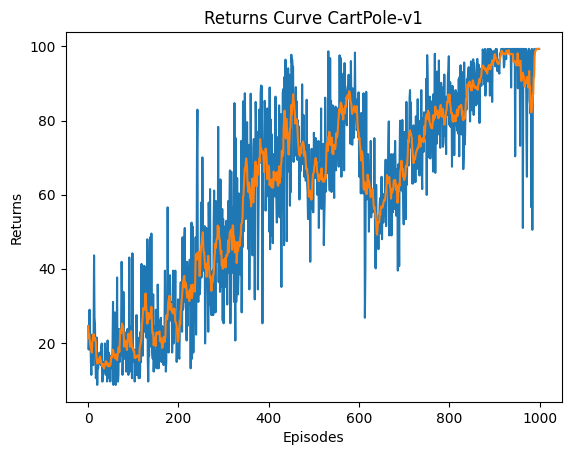

In [8]:
plot_returns_curve(agent.returns, name=name)